In [ ]:
#@title Importing Libraries

import os, requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams 

In [ ]:
#@title Plotting params

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
#@title Loading Spiking times
fname1 = ['steinmetz_st.npz']
fname1.append('steinmetz_wav.npz')
fname1.append('steinmetz_lfp.npz')
url2 = ["https://osf.io/4bjns/download"]
url2.append("https://osf.io/ugm9v/download")
url2.append("https://osf.io/kx3v9/download")


for j in range(len(url2)):
  if not os.path.isfile(fname1[j]):
    try:
      r = requests.get(url2[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname1[j], "wb") as fid:
          fid.write(r.content)


dat_ST = np.load('steinmetz_st.npz', allow_pickle=True)['dat']
dat2 = dat_ST[11]
del dat_ST
print(dat2.keys())

dict_keys(['ss', 'ss_passive'])


In [ ]:
#@title Load Binned Times

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)



alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[11]
print(dat.keys())

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


# Data description

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the following fields:

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_times']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: exact position of the wheel that the mice uses to make a response, binned at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position. 
* `dat['lfp']`: recording of the local field potential in each brain area from this experiment, binned at `10ms`.
* `dat['brain_area_lfp']`: brain area names for the LFP channels. 
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['waveform_w']`: temporal components of spike waveforms. `w@u` reconstructs the time by channels action potential shape. 
* `dat['waveform_u]`: spatial components of spike waveforms.
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `lfp`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 

# Hypothesis

* .....

## Spike Labeling

* We were interested to classify our neurons based on its waveform properties, in order to do that we:

  * label them based on: [(Loren M. Frank, Emery N. Brown, and Matthew A. Wilson, 2001)](https://journals.physiology.org/doi/full/10.1152/jn.2001.86.4.2029) in which putative excitatory neurons (PE) had >0.4 trough to peak time $ms$ and <5 $Hz$ mean firing rate, in the other hand putative inhibitory neurons (FS) had <0.4 trough to peak time and >5 $Hz$ mean firing rate.



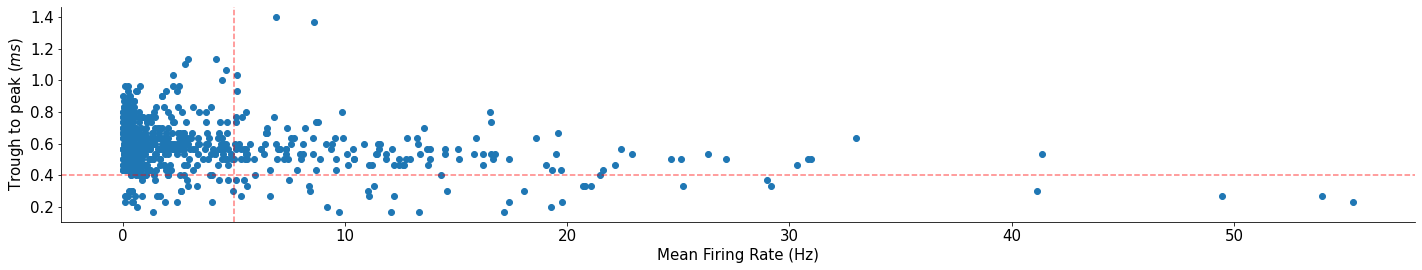

In [ ]:
#@title Boundaries plot

dt_waveforms = 1/30000 # dt of waveform
binsize = dat['bin_size'] # bin times spikes
mean_firing = dat['spks'].mean(axis = (1,2)) * 1/binsize # computing mean firing rate
t_t_peak = dat['trough_to_peak'] * dt_waveforms * 1e3 # computing trough to peak time in ms
plt.scatter(mean_firing,t_t_peak)
plt.axhline(y=0.4,ls = '--', alpha = 0.5, c = 'r')
plt.axvline(x=5,ls = '--', alpha = 0.5, c = 'r')
plt.ylabel('Trough to peak ($ms$)')
plt.xlabel('Mean Firing Rate (Hz)');


Next, we create a dataframe with the related labels:

In [ ]:
#@title Label DataFrame 

import plotly.express as px

labeling_df = pd.DataFrame({
    "Mean Firing Rate": mean_firing,
    "Trough to peak": t_t_peak,
    "Region": dat['brain_area'],
    "Area":dat['brain_area']
})
labeling_df.replace(
    {
        "Area": {"CA1":"Hippocampus","DG":"Hippocampus","SUB":"Hippocampus",
        "VISp": "Visual Ctx", "VISam":"Visual Ctx","MD":"Thalamus","LGd":"Thalamus", "LH":"Thalamus",
        "PL":"Other Ctx","MOs":"Other Ctx","ACA":"Other Ctx"
        }
    }, inplace = True
)

# Labeling according to conditions, other is the default condition
labeling_df['Cell Type'] = "Other"
labeling_df.loc[(labeling_df['Mean Firing Rate']<5)&(labeling_df['Trough to peak']>0.4),'Cell Type'] = "Excitatory"
labeling_df.loc[(labeling_df['Mean Firing Rate']>5)&(labeling_df['Trough to peak']<0.4), 'Cell Type'] = "Inhibitory"

px.scatter(x="Mean Firing Rate", y ="Trough to peak", color = "Cell Type", data_frame = labeling_df)

# Raster plot

* We are now able to separate the **trials** based on *correct and incorrect* responses and separate the **neurons** based on *putative cell type*

<font color='red'>* Inhibitory cells</font> <br/>
<font color='black'>* Other cells</font> <br/>
<font color='blue'>* Excitatory cells</font> 

In [ ]:
#@title raster visualizer
from ipywidgets import interact
import ipywidgets as widgets
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high
is_correct = np.sign(dat['response'])==np.sign(vis_left-vis_right)
def raster_visualizer(area,trial):
  spikes= dat2['ss']
  plt.figure(figsize=(9,5))
  plt.eventplot(spikes[(labeling_df['Area']==area) & (labeling_df['Cell Type']=='Excitatory')][:,trial]);
  plt.eventplot(spikes[(labeling_df['Area']==area) & (labeling_df['Cell Type']=='Other')][:,trial],color='k');
  plt.eventplot(spikes[(labeling_df['Area']==area) & (labeling_df['Cell Type']=='Inhibitory')][:,trial],colors = 'r');
  plt.yticks([]);
  plt.vlines(0.5,0,len(spikes[(labeling_df['Area']==area)])-50,'gray','--',alpha=0.5)
  plt.ylabel('Neurons');
  plt.xlabel('Time ($s$)');
  plt.title(f'Trial was correct?:{is_correct[trial]}')
interact(raster_visualizer, area=['Hippocampus','Visual Ctx','Thalamus','Other Ctx'], trial=(0,339));

interactive(children=(Dropdown(description='area', options=('Hippocampus', 'Visual Ctx', 'Thalamus', 'Other Ct…

In [ ]:
#@title Mean firing rate based on response
# response = dat['response'] # right - nogo - left (-1, 0, 1)

def mean_firing(area):
  Selection = (labeling_df['Area']==area) #& (labeling_df['Cell Type']=='Excitatory')
  spikes = dat['spks'][Selection].mean(axis = 0) #selecting spikes
  mean_fr_e = spikes[is_correct==True].mean(axis=(0))*1/binsize
  mean_fr_i = spikes[is_correct==False].mean(axis=(0))*1/binsize
  time = binsize * np.arange(dat['spks'].shape[-1])
  plt.plot(time, mean_fr_e,label='correct')
  plt.plot(time, mean_fr_i,label='incorrect')
  plt.axvline(x=0.5,ls = '--', alpha = 0.5, c = 'r', label='Stim')
  plt.axvline(x=np.mean(dat['response_time']),ls = '--', alpha = 0.5, c = 'k', label='Response')
  plt.ylabel('Mean Firing Rate ($Hz$)')
  plt.xlabel('Time ($ms$)')
  plt.legend()
interact(mean_firing, area=['Hippocampus','Visual Ctx','Thalamus','Other Ctx']);

interactive(children=(Dropdown(description='area', options=('Hippocampus', 'Visual Ctx', 'Thalamus', 'Other Ct…

# Modeling

* first cell creates the full data frame:
 * each column is a neuron (*except the last one which is the target variable*)
 * each row is a trial
 * each cell is mean firing rate

In this example we are taking the hippocampal region

Available options: Hippocampus, Visual Ctx, Thalamus, Other Ctx
Select the area to visualize:Hippocampus


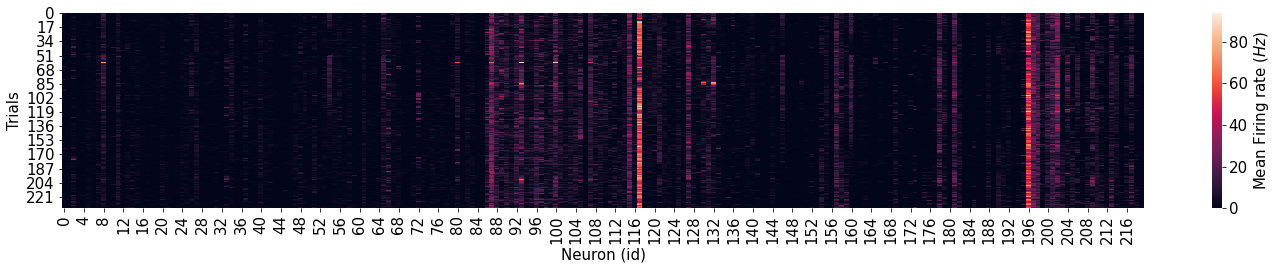

In [ ]:
#@title DataFrame construction

# selects only correct after incorrect trials and correct after correct trials
correct_after_i = np.where(np.diff(is_correct.astype('float32'))==1)[0]
idx_c_c = []
for i in range(len(is_correct)-1):
  if is_correct[i] == 1 & is_correct[i+1]==1:
    idx_c_c.append(i)
  correct_after_c = np.array(idx_c_c)
idx = np.append(correct_after_i,correct_after_c)
c_based_on_pre = np.append(np.array([0]*len(correct_after_i)),np.array([1]*len(correct_after_c)))

def get_full_X_y(area,y):
  bin_spk_hip = dat['spks'][(labeling_df['Area']== area)]
  bin_spk_hip = np.moveaxis(bin_spk_hip[:,:,:50],1,0)
  x= bin_spk_hip.mean(axis=2)
  return x,y

def get_prestim_X_y(area,y):
  bin_spk_hip = dat['spks'][(labeling_df['Area']== area)]
  bin_spk_hip = np.moveaxis(bin_spk_hip,1,0)
  x= bin_spk_hip[idx,:,:50].mean(axis=2)
  return x,y
print('Available options: Hippocampus, Visual Ctx, Thalamus, Other Ctx')
area = input('Select the area to visualize:')
x,y =  get_prestim_X_y(area,c_based_on_pre)

def construct_df(x,y):
  X = pd.DataFrame(x)
  full_df = pd.concat([X,pd.Series(y,name='target')],axis=1)
  return full_df

df = construct_df(x,y)

import seaborn as sns
sns.heatmap(x*1/binsize,cbar_kws={'label':'Mean Firing rate ($Hz$)'});
plt.ylabel('Trials');
plt.xlabel('Neuron (id)');

In [ ]:
#@title Baseline model: Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
print('Available options: Hippocampus, Visual Ctx, Thalamus, Other Ctx')
area = input('Select the area to fit:')
X_full,y_full = get_full_X_y(area,is_correct)
X_pres,y_pres = get_prestim_X_y(area,c_based_on_pre) #Getting the data

def LogReg(X,y):
  model = LogisticRegression(C=1, solver="saga", max_iter=5000)
  Log_model=model.fit(X,y)
  accuracies = cross_val_score(model,X,y,cv=10)
  return Log_model, accuracies

model_full, accuracies_full = LogReg(X_full,y_full)
model_pre, accuracies_pre= LogReg(X_pres,y_pres)

Available options: Hippocampus, Visual Ctx, Thalamus, Other Ctx
Select the area to compare:Hippocampus


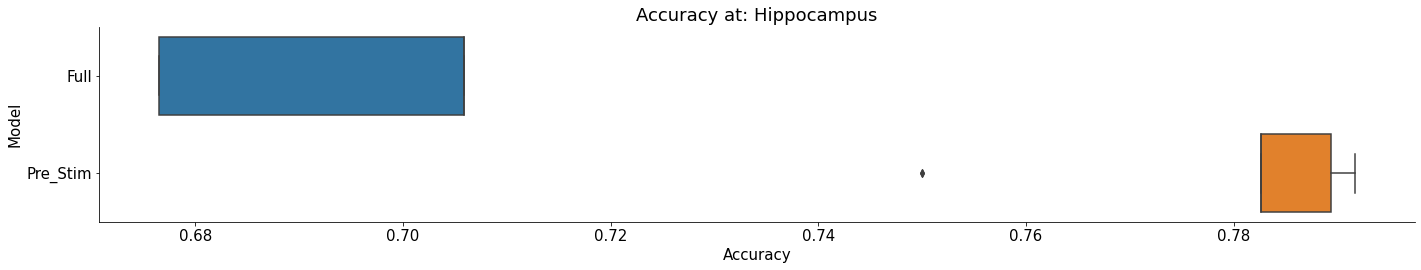

In [ ]:
#@title Comparing Accuracy

output_df = pd.DataFrame({
    'Model': np.concatenate((np.array(["Full"]*10),np.array(["Pre_Stim"]*10))),
    "Accuracy": np.concatenate((accuracies_full,accuracies_pre))
})
sns.boxplot(x='Accuracy',y='Model',data=output_df);
plt.title(f'Accuracy at: {area}');

This results make us think that the the prestimulus activity **could** carry on information related with the previous trial.


*We also detected that we have a class imbalance issue, but we haven't enough time to think in the best way to solve it.*